## 4. Capacity of Recurrent Neural Networks and Hypervectors

Previously, we showed that there is a direct connection between hypercomputing architectures (both Plate and Kanerva) and recurrent neural networks. The hypercomputing algebra can now be used to understand fundamental properties of these neural networks. This is a set of experiments testing the capacity of hypervectors with extrapolation to recurrent neural networks. 

This is to answer some of these questions:
1. What is the relationship with capacity and dimensionality of the hypervector?
2. What is the relationship with capacity and dimensionality of the input?
3. Is there any relationship with capacity and input statistics? i.e. natural language vs. random letters
4. What is the difference between permutation, random orthogonal, and random normal weight matrices?




In [3]:
from pylab import *
import random_idx
import time
%matplotlib inline
from __future__ import division

height has been deprecated.

2016-04-26 13:46


### 4.1 Capacity Random Orthogonal Linear RNNs 

First, we will start with linear RNNs and use the hypervector algebra to store information in these networks as well as decode these networks. With the technique of trajectory association, we imagine that the neural network is receiving a stream of inputs at each time-step. The recurrent feedback weights permutes the past inputs and stores them in the activity of the neurons, which can be decoded using hypercomputing algebra if the weight matrix is known.

In [4]:
def random_orthogonal(n):
    a = np.random.random((n,n))
    q, r = np.linalg.qr(a)
    
    return q

We will also have the neural network store natural language to be sure that the statistics of the letters has no impact on the capacity. 

In [5]:
def test_capacity_natural_ro(N, ro, K=5):
    letter_vectors = 2 * (np.random.randn(len(random_idx.alphabet), N) > 0) - 1

    letter_sequence='''this hypervector is going to contain a lot of letters at some point it will run out of capacity and it should 
    no longer be capable of storing patterns indefinitely the dimensionality of the hypervectors will play an important role in its 
    capacity understanding the relationship between dimensionality and capacity is extremely important and wow you can totally put a
    lot more letters in the hypervector than i expected with one thousand dimensions you can easily store one hundred letters in the 
    hypervector with no loss and using a totally random orthogonal matrix this is pretty crazy it seems to be quite noisy for a while 
    but it still retains some information capacity i had to go back and add these letters to push it further and get to the point where 
    it was clearly going haywire the other thing is that the values of the hypervector are also continually increasing'''

    hypercapacity = np.zeros(N)

    # we have ro, but lets also store read out matrices
    last_input = np.linalg.matrix_power(ro, -1)
    input_K = np.linalg.matrix_power(ro, -K)
    first_input = np.linalg.matrix_power(ro, -1) # this one we will build up continuously

    tstart = time.time()
    lidx = np.zeros(len(letter_sequence))
    lidx[0] = random_idx.alphabet.find(letter_sequence[0])
    hypercapacity = np.dot(ro, hypercapacity) + letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(len(letter_sequence))
    lidx_input_K = np.zeros(len(letter_sequence))
    lidx_first_input = np.zeros(len(letter_sequence))

    for i,l in enumerate(letter_sequence[1:]):
        lidx[i+1] = random_idx.alphabet.find(l)

        hypercapacity = np.dot(ro, hypercapacity) + letter_vectors[lidx[i+1], :]

        v_last_input = np.dot(last_input, hypercapacity)
        v_input_K = np.dot(input_K, hypercapacity) # we can still do this less than K, it will just be noise
        v_first_input = np.dot(first_input, hypercapacity)
        first_input = np.dot(last_input, first_input) # we have to continually update this readout matrix

        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

        lli = random_idx.alphabet[int(lidx_last_input[i])]
        liK = random_idx.alphabet[int(lidx_input_K[i])]
        lfi = random_idx.alphabet[int(lidx_first_input[i])]

        #print '%03d:' % i, l, lli, liK, lfi

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [ ]:
#test_N = [100, 200, 500]
test_N = [100, 500, 1000, 5000, 10000]
runs = 5

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_natural_ro(N, random_orthogonal(N))
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-natural_ro-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N)

In [8]:
h = np.load('data/hypervector_capacity-natural_ro-N=5-r=5-n160315.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
## HACK ##
runs = 5
test_N = [100, 500, 1000, 5000, 10000]

run_id = np.arange(len(lidx_all))
run_N = test_N * runs
##

In [9]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)
K=5

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


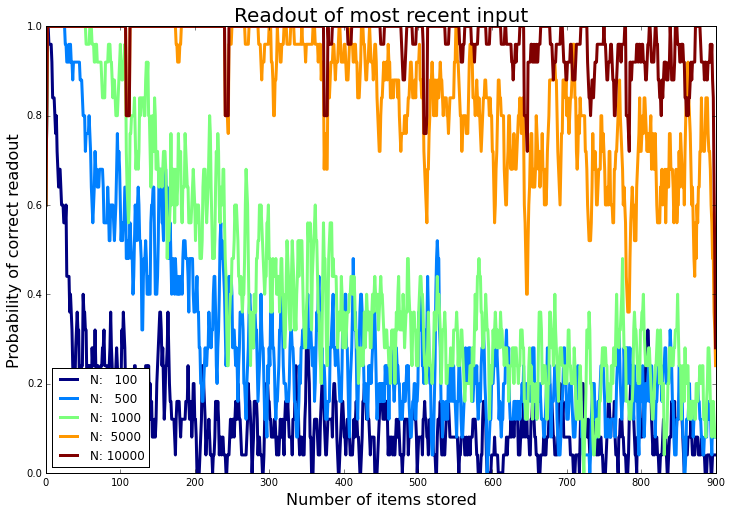

In [10]:
figure(figsize=(12,8))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

**Figure 4.1. Capacity of Hyper-RNN:** A string of 900 characters was sequentially stored in a hyper-rnn with random orthogonal weights. The readout of the most recent input falls off at different rates depending on the dimensionality. A 1000-D hyper-rnn can store over 50 memories of 27 characters without mistakes. Once the Hyper-RNN begins to fill up its information content per item diminishes until the item is recovered at near chance level. 

### 4.2 Capacity of Equivalent Hypervector

We will next create a hypervector that has the same properties as the linear RNN. We show that the capacity is the same, and that the statistics of the letters do not matter. This will enable us to much more thoroughly explore the capacity of such networks and the relationships to their dimensionality as well as the input's dimensionality (the computations are way faster, too). Further, we can use the hypervector algebra and the translation to RNNs to make conclusions about the information capacity of RNNs and other systems which store information using high-dimensional vectors.


In [33]:
def test_capacity_independent_roll(N, D, K=5, trials=5e3):
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1

    hypercapacity = np.zeros(N)

    tstart = time.time()
    lidx = np.zeros(trials)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    lidx_last_input = np.zeros(trials)
    lidx_input_K = np.zeros(trials)
    lidx_first_input = np.zeros(trials)

    for i in range(int(trials)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        v_last_input = np.roll(hypercapacity, -1)
        v_input_K = np.roll(hypercapacity, -K) # we can still do this less than K, it will just be noise
        v_first_input = np.roll(hypercapacity, -(i+1))
        
        lidx_last_input[i] = argmax(np.dot(letter_vectors, v_last_input.T))
        lidx_input_K[i] = argmax(np.dot(letter_vectors, v_input_K.T))
        lidx_first_input[i] = argmax(np.dot(letter_vectors, v_first_input.T))

    print 'Duration: ', time.time() - tstart
    
    return lidx, lidx_last_input, lidx_input_K, lidx_first_input

In [34]:
test_N = [100, 500, 1000, 5000, 10000]
#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []
K = 5

for r in range(runs):
    print r
    for N in test_N:
        lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_independent_roll(N, len(random_idx.alphabet), K=K)
        
        run_id.append(r)
        run_N.append(N)
        lidx_all.append(lidx)
        lidx_li_all.append(lidx_li)
        lidx_iK_all.append(lidx_iK)
        lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-independent_roll-N=' + str(len(test_N)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, runs=runs, test_N=test_N, K=K)


0
Duration:  0.172707080841
Duration:  0.361740112305
Duration:  0.499460935593
Duration:  1.81243610382
Duration:  3.54784917831
1
Duration:  0.159857988358
Duration:  0.352649927139
Duration:  0.560857057571
Duration:  2.04241394997
Duration:  3.46585297585
2
Duration:  0.151731014252
Duration:  0.357144117355
Duration:  0.490930080414
Duration:  1.90141916275
Duration:  3.51702618599
3
Duration:  0.156320810318
Duration:  0.311619997025
Duration:  0.542809963226
Duration:  1.93949699402
Duration:  3.60311412811
4
Duration:  0.154901027679
Duration:  0.353985071182
Duration:  0.510078907013
Duration:  1.9157948494
Duration:  3.53521704674
data/hypervector_capacity-independent_roll-N=5-r=5-n160424.npz


/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:7: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:9: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:13: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/epaxon/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:19: Depre

In [61]:
h = np.load('data/hypervector_capacity-independent_roll-N=5-r=5-n160419.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
run_id = h['run_id']
run_N = h['run_N']
runs = h['runs']
test_N = h['test_N']
#K = h['K']

In [35]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)
uN = np.array([100, 500, 1000, 5000, 10000])

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


(0, 900)

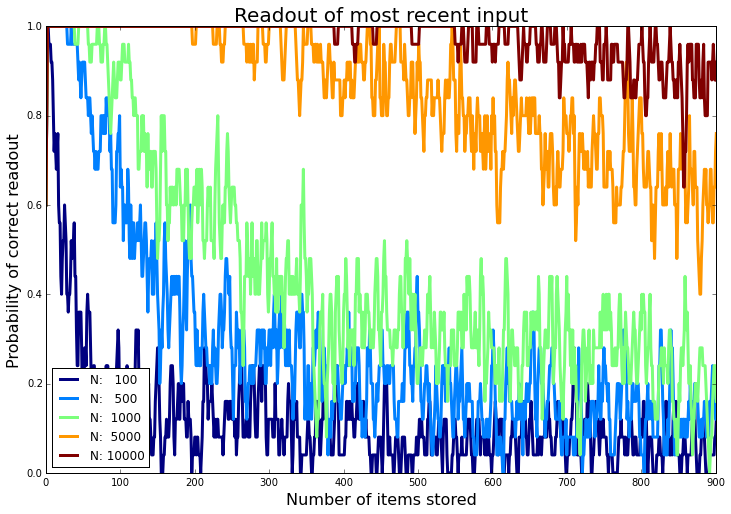

In [36]:
figure(figsize=(12,8))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
xlim([0, 900])

** Figure 4.2. The Capacity of the Equivalent Hypervector to the RNN.**

The capacities are the same, and this should be expected due to the efforts we went through connecting the algebra to the weight matrix. However, the algebra is *way* faster to simulate so we can explore the capacity more thoroughly by just relying on the faster `np.roll` operation instead of a matrix multiply. So we can see what happens as we add many more items.

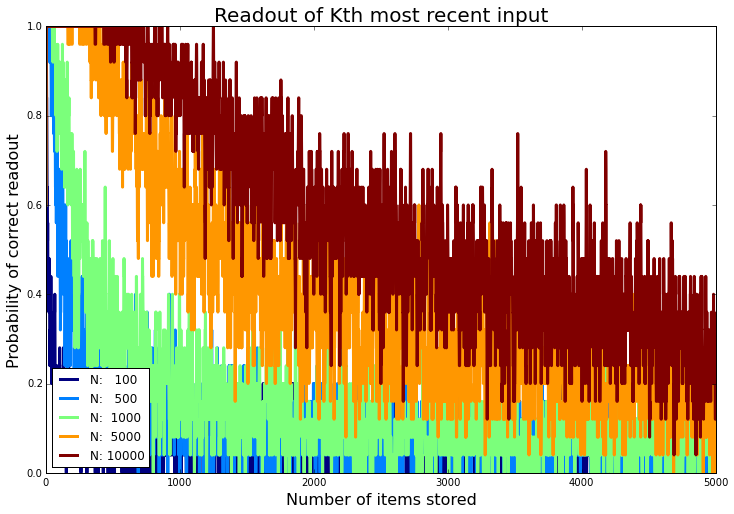

In [10]:
figure(figsize=(12,8))
cm=get_cmap('jet', iK_mean.shape[1])

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left')
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

**Figure 4.3. Readout of Kth most recent input versus items stored:** Utilizing the more efficient hypervector operations allows us to explore the capacity much faster and for much larger N.

We can look back into the recurrent neural network a fixed number of steps and get a very similar curve. This curve is realted to the first curve typically, because if the network makes a mistake after only 1 step, it is likely to make the same mistake after K steps. In this case K is pretty small, so the curves look very similar, and they will have noise correlations.


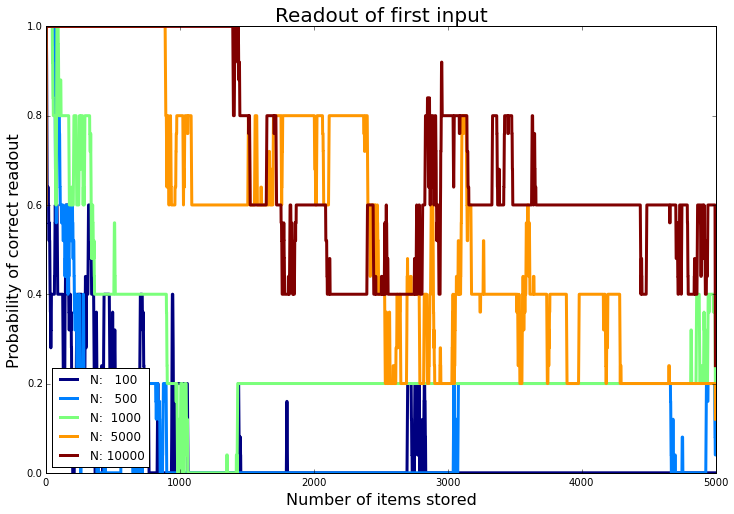

In [11]:
figure(figsize=(12,8))
cm=get_cmap('jet', fi_mean.shape[1])

for i in range(fi_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(fi_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left')
title('Readout of first input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

** Figure 4.4. Readout of First Input:** The curves are box/clunky because the answer is always the same letter.

We also kept track of a matrix to read out the very initial input into the neural network and this has similar decay properties. This is more jagged becaues the first input is always the same letter, and so the network is right or wrong for extended periods of time by chance, since each check is correlated.



### 4.3 Capacity with Large N

Now we can explore much higher-dimensional hypervectors, because we do not have to suffer through the computations of thousands of 1000x1000 matrix multiplies. Next, we will vary N proportionally, and see that the capacity decay is smoothly related to the size of N.

In [ ]:
test_N = [1000, 3000, 9000, 27000, 81000]
test_D = [32]

#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
run_D = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

K=5

for r in range(runs):
    print r
    for N in test_N:
        for D in test_D:
            lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_independent_roll(N, D, K=K)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            lidx_li_all.append(lidx_li)
            lidx_iK_all.append(lidx_iK)
            lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-proportional_N-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, run_D=run_D, runs=runs, test_N=test_N, test_D=test_D, K=K)


In [13]:
h = np.load('data/hypervector_capacity-proportional_N-N=5-D=1-r=5-n160419.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']

run_id = h['run_id']
run_N = h['run_N']
runs = h['runs']
test_N = h['test_N']
#K = h['K']

In [14]:
run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')  
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


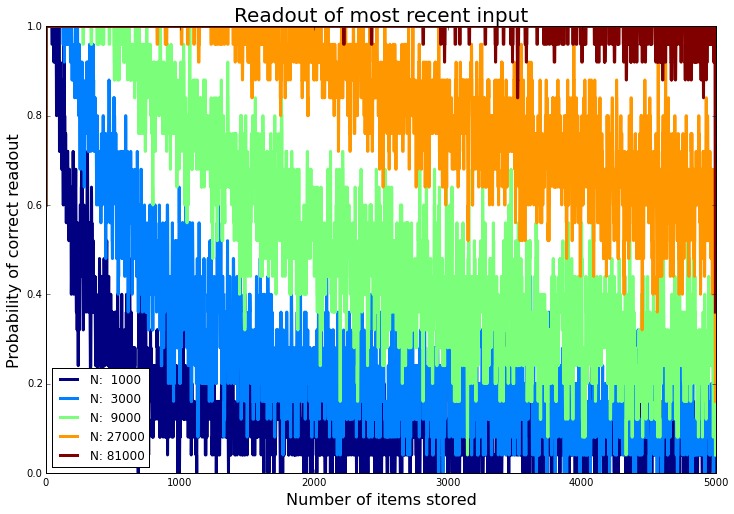

In [15]:
figure(figsize=(12,8))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

**Figure 4.5. Memory decay varies smoothly with proportional N:** We created the capacity curve for hypervectors with different dimensionalities. By increasing N proportionally (3x) in each curve, we can see a clear pattern in the relationship with capacity and dimensionality.

Becoming more clear that there is a direct relationship with these curves and the particular value of N used.

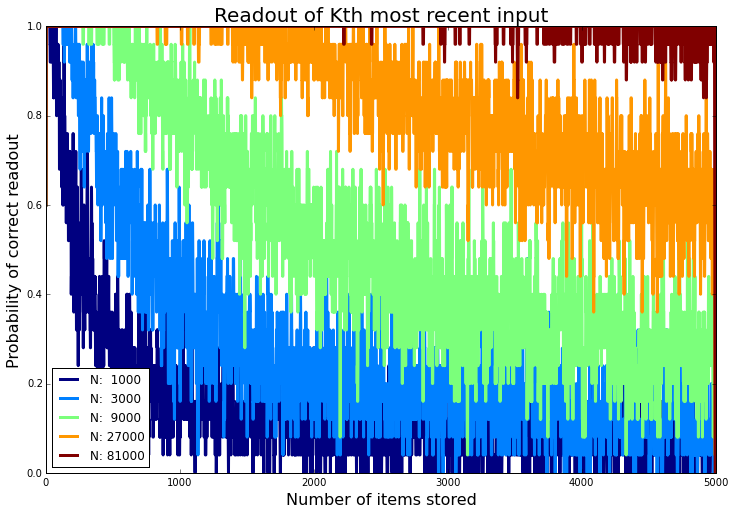

In [16]:
figure(figsize=(12,8))
cm=get_cmap('jet', iK_mean.shape[1])

for i in range(iK_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), color=cm(i), lw=3, label="N: %5i" % test_N[i])
    
legend(loc='lower left');
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

**Figure 4.6. Memory decay varies smoothly with proportional N:** We see pretty much the same capacity curve when we measure the element that was stored $K=5$ timesteps ago.

### 4.4 Capacity and dimensionality of tokens

Another factor that affects the capacity of the hypervector is the dimensionality of the tokens. In the above examples, we have been storing the fixed tokens of 'abcd...xyz\_'. The hypervector or rnn would receive one of these 27 possibilities at each time point, which we will now vary and we will call the number of possible tokens $D$. 

We can change $D$ by adding more letter tokens. e.g. we could include all lower and upper case letters and have 53 tokens, we could include all punctuation and have even more. 

We can also note a potential relationship between sparsity of the input and $D$. Note that the input is always 1-sparse of $D$, so the input structure is 1-sparse and has a dimensionality of $D$.  We could imagine a different kind of input stream into an RNN, where the input is 2-sparse: i.e. you get two letters simultaneously. However, this can be translated into a 1-sparse representation with $D^2$ number of tokens. This could be used to fundamentally connect an input stream's dimensionality with its sparsity.


In [ ]:
test_N = [1000]
test_D = [2, 8, 32, 128, 512, 2048, 8192]
#test_D = [2, 8, 32, 128]


#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 5

run_id = []
run_N = []
run_D = []
lidx_all = []
lidx_li_all = []
lidx_iK_all = []
lidx_fi_all = []

K=5

for r in range(runs):
    print r
    for N in test_N:
        for D in test_D:
            
            lidx, lidx_li, lidx_iK, lidx_fi = test_capacity_independent_roll(N, D, K=K, trials=5e4)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            lidx_li_all.append(lidx_li)
            lidx_iK_all.append(lidx_iK)
            lidx_fi_all.append(lidx_fi)
        
filename = 'data/hypervector_capacity-proportional_N-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, lidx_li_all=lidx_li_all, lidx_iK_all=lidx_iK_all, lidx_fi_all=lidx_fi_all,
        run_id=run_id, run_N=run_N, run_D=run_D, runs=runs, test_N=test_N, test_D=test_D, K=K)


In [62]:
h = np.load('data/hypervector_capacity-proportional_N-N=1-D=7-r=5-n160419.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']

run_id = h['run_id']
run_N = h['run_N']
run_D = h['run_D']
runs = h['runs']
test_N = h['test_N']
test_D = h['test_D']

#K = h['K']

In [63]:
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uD)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uD)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uD)))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for i in idxs:
        li_mean[:,iD] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iD] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iD] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


In [64]:
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

li_all = np.zeros((lidx_li_all[0].shape[0], len(uD), runs))
iK_all = np.zeros((lidx_iK_all[0].shape[0], len(uD), runs))
fi_all = np.zeros((lidx_fi_all[0].shape[0], len(uD), runs))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for ii,i in enumerate(idxs):
        li_all[:,iD,ii] = np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_all[:,iD,ii] = np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_all[:,iD,ii] = np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')

li_mean = np.mean(li_all, axis=2)    
iK_mean = np.mean(iK_all, axis=2)    
fi_mean = np.mean(fi_all, axis=2)    

(0, 500)

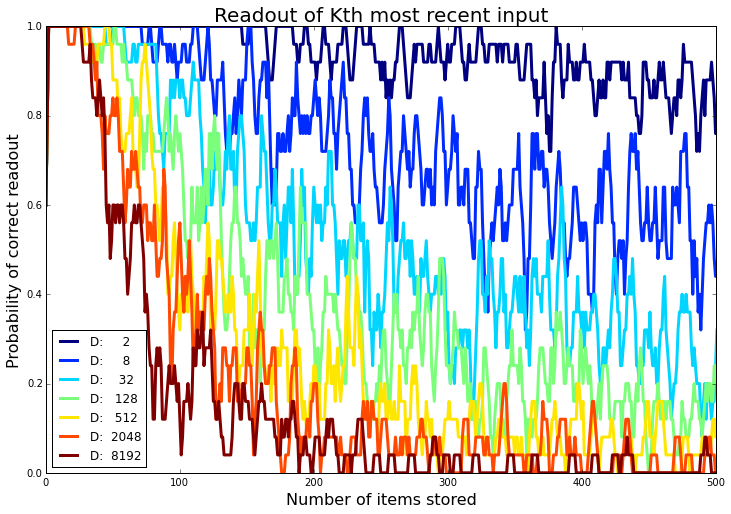

In [65]:
figure(figsize=(12,8))
cm=get_cmap('jet', iK_mean.shape[1])
         
for i in range(iK_mean.shape[1]):
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), 
         color=cm(i), lw=3, label="D: %5i" % test_D[i])

legend(loc='lower left')
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)
xlim([0,500])

**Figure 4.7. Varying the dimensionality of the tokens with fixed N:** More items can be stored if the number of possible items is smaller. 

Smoothly varying the dimensionality of the tokens (e.g. letters is $D=27$) increase the rate of fall-off.

Having more tokens means that the network stores more bits per token. If we normalize these curves based on the number of bits each token itself contains, then we see another very important relationship.

In [206]:
figure(figsize=(8,6))

cm=get_cmap('jet', iK_mean.shape[1])

for j in range(iK_all.shape[2])[::-1]:
    for i in range(iK_all.shape[1]):
        #plot(li_mean[:,i], color=cm(i))
        smoothN = 5
        pp = np.convolve(iK_all[:,i,j], np.ones(smoothN)/smoothN, mode='same')
        plot(np.log2(test_D[i] * pp) * pp, ':',
             color=cm(i), lw=1)
        
smoothN=5
for i in range(iK_mean.shape[1])[::-1]:
    #plot(li_mean[:,i], color=cm(i))
    pp = np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same')
    plot(np.log2(test_D[i] * pp) * pp,
         color=cm(i), lw=3, label="D: %5i" % test_D[i])
    
legend(loc='upper right');
title('Readout Bits of Kth most recent input', fontsize=20);
xlabel('Number of Items stored', fontsize=16);
ylabel('Readout Bits', fontsize=16)
xlim([0,1000])

NameError: name 'iK_all' is not defined

**Figure 4.8. Decay of memory in bits is consistent regardless of bits per token:** The fraction correct curves were translated to bits based on the number of possible tokens (e.g. getting a token correct when there is two possible tokens gives 1 bit, when a correct token out of eight gives 3 bits). 

This curve points to a maximum level of bits that can be stored in the hypervector. Integral of this curve will approach the maximum. 

These curves at least seem to be similar, it may be possible that they are not. It makes some sense that the time-constants of these curves would decrease as D gets large.


### 4.5 Total number of bits capable of being stored in the hypervector

To best estimated the total capacity of the data in the hypervector, we will attempt to read out as much information as possible from the hypervector as we fill it up. We will compare how many total bits can be read versus how many bits that are added to the memory.


In [240]:
# with this function, we are going to try and readout everything in the hypervector each time we add something
def test_capacity_D_totalbits(N, D, bit_factor=20, trials=5e2):
    
    letter_vectors = 2 * (np.random.randn(D, N) > 0) - 1
    hypercapacity = np.zeros(N)

    tstart = time.time()
    
    bit_ratio = floor(bit_factor / np.log2(D))
    
    lidx = np.zeros(trials * bit_ratio)
    lidx[0] = np.random.randint(D)
    hypercapacity = letter_vectors[lidx[0], :]

    totalbits = np.zeros(trials)

    for i in range(int(trials * bit_ratio)-1):
        
        lidx[i+1] = np.random.randint(D)

        hypercapacity = np.roll(hypercapacity, 1) + letter_vectors[lidx[i+1], :]

        if mod(i+1, bit_ratio) == 1:
            iscorrect = np.zeros(i+1)
            for j in range(i+1):
                v_total = np.roll(hypercapacity, -(i-j))
                iscorrect[j] = float(lidx[j+1] == argmax(np.dot(letter_vectors, v_total.T)))
            
            t = i // bit_ratio
            #totalbits[t] = (1.0/(1-1.0/D)) * len(iscorrect) * np.log2(D) * (np.mean(iscorrect) - 1.0/D)            
            totalbits[t] = len(iscorrect) * np.mean(iscorrect) * log2(np.mean(iscorrect) * D)
            #print np.mean(iscorrect),
            #totalbits[i] = len(iscorrect) * np.log2(D) * (mean(iscorrect))
            
            
    print 'Duration: ', time.time() - tstart
    
    return lidx, totalbits

32768

In [ ]:
test_N = [10000]
#test_D = [2, 4, 128]
test_D = [2, 4, 8, 2**5, 2**7, 2**10, 2**15]

#test_N = [100, 300, 900, 2700, 8100, 24300]
runs = 3#5

run_id = []
run_N = []
run_D = []
lidx_all = []
totalbits_all = []
bit_factor=20 # this makes it calculate the storage every 20 bits we add
for r in range(runs):
    print r
    for N in test_N:
        for D in test_D:
            lidx, totalbits = test_capacity_D_totalbits(N, D, bit_factor=bit_factor, trials=2000)
        
            run_id.append(r)
            run_N.append(N)
            run_D.append(D)
            lidx_all.append(lidx)
            totalbits_all.append(totalbits)

filename = 'data/hypervector_capacity-totalbits-N=' + str(len(test_N)) + '-D=' + str(len(test_D)) + '-r=' + str(runs) + '-n' + time.strftime('%y%m%d') + '.npz'
print filename
np.savez(filename, lidx_all=lidx_all, totalbits_all=totalbits_all, bit_factor=bit_factor,
        run_id=run_id, run_N=run_N, run_D=run_D, runs=runs, test_N=test_N, test_D=test_D)


In [ ]:
h = np.load('data/hypervector_capacity-totalbits-N=1-D=5-r=5-n160426.npz')
lidx_all = h['lidx_all']
totalbits_all = h['totalbits_all']

run_id = h['run_id']
run_N = h['run_N']
run_D = h['run_D']
runs = h['runs']
test_N = h['test_N']
test_D = h['test_D']


In [ ]:
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

tb_all = np.zeros((totalbits_all[0].shape[0], len(uD), runs))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for ii,i in enumerate(idxs):
        tb_all[:,iD,ii] = np.array(totalbits_all[i])
        
tb_mean = np.mean(tb_all, axis=2)

In [ ]:
figure(figsize=(8,8))

plot_range = [0,test_N[0]*2]

cm=get_cmap('jet', tb_mean.shape[1])
smoothN=1
for i in range(tb_all.shape[1]):
    for j in range(tb_all.shape[2]):
        #plot(li_mean[:,i], color=cm(i))    
        bit_ratio = bit_factor // np.log2(test_D[j])
        plot(np.log2(test_D[j]) * bit_ratio *(arange(tb_all.shape[0]) + 1) + 1, 
             tb_all[:,i,j], ':', color=cm(i), lw=1)
        
        
for i in range(tb_mean.shape[1]):
    bit_ratio = bit_factor // np.log2(test_D[j])

    plot(np.log2(test_D[j]) * bit_ratio * (arange(tb_mean.shape[0]) + 1) + 1,
        tb_mean[:,i], color=cm(i), lw=2, label="Mean, D: %5i" % test_D[i])
        

plot(plot_range, plot_range, 'k')
uD = unique(run_D)
uN = unique(run_N)

for idxD, iD in enumerate(uD):
    for idxN, iN in enumerate(uN):
        bit_ratio = bit_factor / np.log2(iD)
  
        M = np.linspace(1, bit_ratio * tb_mean.shape[0], tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        pp = p_correct_l2(M, N=iN, D=iD)
        plot(np.log2(iD) * (M), 
             #M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
             M * pp * log2(pp*iD), '--',
             color=cm(idxD), lw=3, label="Theory, D: %5i" % test_D[i])  
legend(loc='upper left');
title('Total bits readable from hypervector', fontsize=20);
xlabel('Number of bits added', fontsize=16);
ylabel('Total bits read', fontsize=16)
xlim(np.array(plot_range)/4)
ylim(np.array(plot_range)/4)


(0, 4000)

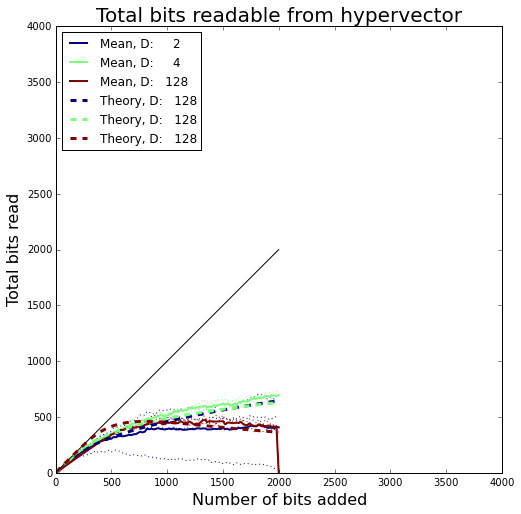

In [239]:
figure(figsize=(8,8))

plot_range = [0,test_N[0]*2]

cm=get_cmap('jet', tb_mean.shape[1])
smoothN=1
for i in range(tb_all.shape[1]):
    for j in range(tb_all.shape[2]):
        #plot(li_mean[:,i], color=cm(i))    
        plot(bit_factor * (arange(tb_all.shape[0]) + 1), 
             tb_all[:,i,j], ':', color=cm(i), lw=1)
        
        
for i in range(tb_mean.shape[1]):
    plot(bit_factor * (arange(tb_mean.shape[0])+1),
        tb_mean[:,i], color=cm(i), lw=2, label="Mean, D: %5i" % test_D[i])
        

plot(plot_range, plot_range, 'k')
uD = unique(run_D)
uN = unique(run_N)

for idxD, iD in enumerate(uD):
    for idxN, iN in enumerate(uN):
        bit_ratio = bit_factor / np.log2(iD)
  
        M = np.linspace(1, bit_ratio * tb_mean.shape[0], tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        pp = p_correct_l2(M, N=iN, D=iD)
        plot(np.log2(iD) * (M), 
             #M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
             M * pp * log2(pp*iD), '--',
             color=cm(idxD), lw=3, label="Theory, D: %5i" % test_D[i])  
legend(loc='upper left');
title('Total bits readable from hypervector', fontsize=20);
xlabel('Number of bits added', fontsize=16);
ylabel('Total bits read', fontsize=16)
xlim([0, 4000])
ylim([0, 4000])


In [223]:
tb_mean[2,-1]

28.0

**Figure 4.9. The cumulative total information stored in the hypervector:** We read out all the information (i.e. the entire history of the sequence) as we added more and more elements and plotted the bits that were read out versus the bits that were added. The black line indicates an equivalent amount of bits read and added. The hypervectors initially store all of the infomration reliably, but this falls off to a saturation level as the capacity is approached. (Noise can make this measurement drift and the variance of the bits read increases due to this noise as more bits are added.) 

The capacity is based on the total number of bits that are added to the hypervector. When there are more potential tokens, less tokens can be stored, but there are more bits per token and these effectively cancel out. 


### 4.6 Analytic Derivation of Hypervector Capacity

From these experiments, we see that the hypervector has a limited capacity, and as we fill up the hypervector we have less and less information about each element being stored. 

One approach to estimating this information decay would be to consider the very extreme case where $D=2^N$ -- i.e. every binary vector is a token. This is a fundamental limit -- we can add one of these hypervectors (i.e. a random binary vector, say $a$) and we will have N bits of information stored in the hypervector. If we permuted $a$, then we would have a different token in the set and so we cannot recover any information. Such a hypervector would then store N bits of information if given a single input, but any further input eliminates all information in the hypervector -- i.e. the hypervector could be made out of ambiguous elements.

Consider four hypervectors, $a,b,c,d$ in the set of all $2^N$, which are exactly the same except at 4 different places:

$$
    a = [..., 1, 1, -1, -1, ...] \\
    b = [..., -1, -1, 1, 1, ...] \\
    c = [..., -1, 1, -1, 1, ...] \\
    d = [..., 1, -1, 1, -1, ...] \\
$$

Each of these hypervectors are unique, and so if you tried to make a hypervector out of 2 of them, you would get confused.

$$
    h_{ab} = a + b = [..., 0, 0, 0, 0, ...] \\
    h_{cd} = c + d = [..., 0, 0, 0, 0, ...]
$$

And this is generally true for any pair of hypervectors given that the full set of $2^N$ tokens are available. Thus such a hypervector can store only one element from this set, but luckily that element has a ton of information -- N bits! But of course this must be the limit of the hypervector's capacity (well, the values in a superposition like $h$ don't have to be binary, and so maybe it could store more than N bits, since it is itself more than N bits. Yet, I think with the structure of the basic elements this is the case).



### Plate Derivation



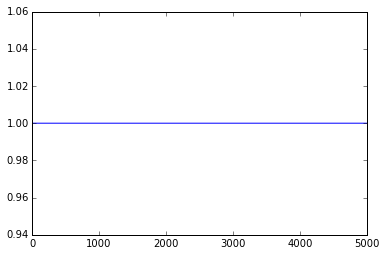

In [6]:
import scipy

test_D = [20]
test_N = [2000]

M = np.arange(0, 5000)

for idxN,N in enumerate(test_N):
    for idxD,D in enumerate(test_D):
        p_correct = (1 - scipy.special.erf(-(N/(2*M-1))**0.5))**(M*(D-1))
        p_correct[p_correct>1] = 1
        plot(M, p_correct)
        

        

### Sommer Derivation

We have an alphabet of size $D$, where each token is encoded by a random $N$-dimensional i.i.d. bipolar vector $\{X_{\gamma} \in \{-1,1\}^N : \gamma = 1, ..., D\}$. A sequence of M letters is stored in an integer-valued vector $Y$ through the technique of trajectory-association:

$$
    Y = \sum_{\mu=1}^{M} P^{\mu} X^{\mu}_{\gamma}
$$

where P is a "general" permutation operation. This operation on any $X_{\gamma}$ creates a new i.i.d. random vector.The sequence is decoded by dereferencing the position of the letter in the sequence (i.e. applying the inverse permutation) to get $Y^{-\mu}$, and taking the maximum dot-product of each element in $D$ with the dereferenced sequence.

$$
    token = argmax (D Y^{-\mu})
$$

Without loss of generality, we assume that ($g$)-th element of $D$ was stored as the ($m$)-th element in the sequence. The probability of correcly decoding this element is based on the distributions of two dot products, the value of the correct element in the sequence ($A$) and the value of the incorrect elements ($B$). The distribution of the correct element is given by:

$$
    A := (X_g)^TY^{-m} = \sum_{i=1}^{N} X_g(i) \left( X_g(i) + \sum_{\mu=2}^{M} P^{\mu} X^{\mu}_{\gamma}(i) \right)
$$

The dot product of any element with $D$ with itself will have a value of $N$, and the dot product of any two random hypervectors can be approximated by a normal distribution:

$$
    A := N + \sum_{i=1}^N \sum_{\mu=2}^M X_g (i) P^{\mu} X_{\gamma}^{\mu} (i) \approx \mathscr{N}(N; (M-1)N) 
$$

The distribution of the dot products for an incorrect element:

$$
    B := (X_{\gamma^*})^TY^{-m} = \sum_{i=1}^N \sum_{\mu=1}^M X_{\gamma^*} (i) P^{\mu} X_{\gamma}^{\mu} (i) \approx \mathscr{N}(0; MN)
$$

where $\gamma^* \ne g$. The $B$ distribution must not exceed the $A$ distribution for any of the incorrect $D-1$ elements, which gives the probability of correctly decoding $X_g$ as:

$$
    p_{corr} = \int_{-\infty}^{\infty} p_A(a) [p_B(b < a)]^{D-1} da \\
    p_{corr} = \int_{-\infty}^{\infty} \frac{da}{\sqrt{2\pi}} e^{-\frac{(a-N)^2}{2(M-1)N}} \left[ \Phi \left( \frac{a}{\sqrt{MN}} \right) \right] ^ {D-1}
$$

where $\Phi$ is the normalized cumulative gaussian distribution. 


In [198]:
def ncdf(z):
    return 0.5 * (1 + scipy.special.erf(z/2**0.5))

def p_correct_l(M, N=10000, D=27):
    M = np.array(M)
    avals = np.linspace(N - 5*(N*np.max(M))**0.5, N + 5*(N*np.max(M))**0.5, 20000)
    p = np.zeros((len(avals)-1, len(M)))
    
    for ia,a in enumerate(avals[1:]):
        p[ia, :] = ncdf(float(avals[ia+1]-N)/((M-1)*N)**0.5) - ncdf(float(avals[ia]-N)/((M-1)*N)**0.5)
        p[ia, :] *= (ncdf(np.mean(avals[ia:(ia+1)])/(M*N)**0.5)) ** (D-1)
    return np.sum(p, axis=0)

def p_correct_l2(M, N=10000, D=27, ares=2000):
    M = np.array(M)
    p = np.zeros((ares-1, len(M)))

    for iM,Mval in enumerate(M):
        avals = np.linspace(N - 8 * (N*Mval)**0.5, N + 8 * (N*Mval)**0.5, ares)
        
        p[:, iM] = ncdf((avals[1:]-N) / ((Mval-1)*N)**0.5) - ncdf((avals[:-1]-N) / ((Mval-1)*N)**0.5)
        p[:, iM] *= (ncdf(np.mean(np.vstack((avals[1:], avals[:-1])), axis=0)/(Mval*N)**0.5)) ** (D-1)

    return np.sum(p, axis=0)

(0, 20000)

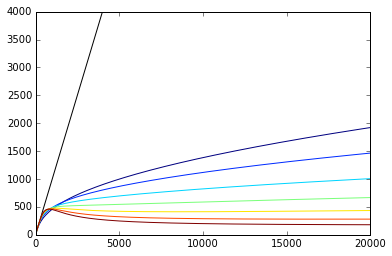

In [199]:
plot(plot_range, plot_range, 'k')

uD  = [2,4,8,16,32,64,128]
uN = [1000]
cm=get_cmap('jet', len(uD))

for idxD, iD in enumerate(uD):
    for idxN, iN in enumerate(uN):
        bit_ratio = bit_factor / np.log2(iD)
  
        M = np.linspace(1, 5*bit_ratio * tb_mean.shape[0], tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        pp = p_correct_l2(M, N=iN, D=iD)
        plot(np.log2(iD) * (M), 
             #M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
             M * pp * log2(pp*iD),
             color=cm(idxD), lw=1)
        
ylim([0, 4000])
xlim([0, 20000])

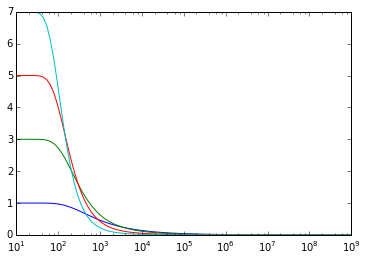

In [183]:
M = np.logspace(1, 9, 100)
Ds = [2, 8, 32, 128]

for D in Ds:
    pp = p_correct_l2(M, N=1000, D=D)
    plot(M, pp * log2(pp*D))
    
xscale('log')

In [143]:
M

array([ 10.,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,  inf,
        inf])

(0, 2000)

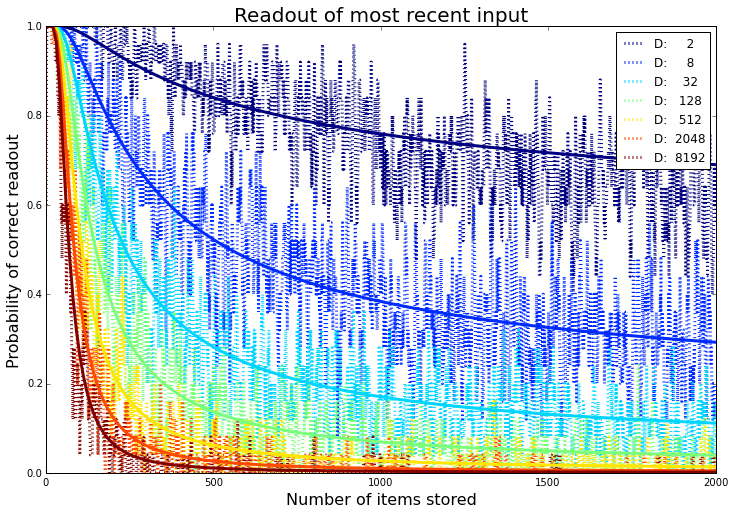

In [110]:
import scipy

h = np.load('data/hypervector_capacity-proportional_N-N=1-D=7-r=5-n160419.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']

run_id = h['run_id']
run_N = h['run_N']
run_D = h['run_D']
runs = h['runs']
test_N = h['test_N']
test_D = h['test_D']
K = h['K']
run_id = np.array(run_id)
run_D = np.array(run_D)

uD = unique(run_D)

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uD)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uD)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uD)))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for i in idxs:
        li_mean[:,iD] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iD] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iD] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs

figure(figsize=(12,8))
cm=get_cmap('jet', iK_mean.shape[1])
smoothN = 5

for i in range(iK_mean.shape[1]):
    plot(np.convolve(iK_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), ':',
         color=cm(i), lw=3, label="D: %5i" % test_D[i])

legend(loc='lower left')
title('Readout of Kth most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

M = np.arange(1, iK_mean.shape[0], 10)
 #Phi(z) = 1/2[1 + erf(z/sqrt(2))]
for idxN,N in enumerate(test_N):
    for idxD,D in enumerate(test_D):
        p_correct = p_correct_l2(M, N=N, D=D)
        plot(M, p_correct, color=cm(idxD),lw=3)

legend(loc='upper right');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

xlim([0,2000])

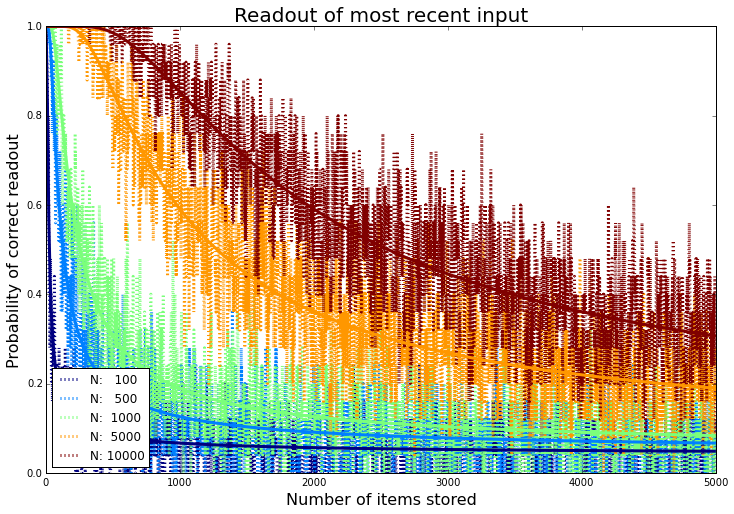

In [108]:
import scipy

h = np.load('data/hypervector_capacity-independent_roll-N=5-r=5-n160419.npz')
lidx_all = h['lidx_all']
lidx_li_all = h['lidx_li_all']
lidx_iK_all = h['lidx_iK_all']
lidx_fi_all = h['lidx_fi_all']
run_id = h['run_id']
run_N = h['run_N']
runs = h['runs']
test_N = h['test_N']
#K = h['K']
test_D = [27]

run_id = np.array(run_id)
run_N = np.array(run_N)

uN = unique(run_N)
K=5

li_mean = np.zeros((lidx_li_all[0].shape[0], len(uN)))
iK_mean = np.zeros((lidx_iK_all[0].shape[0], len(uN)))
fi_mean = np.zeros((lidx_fi_all[0].shape[0], len(uN)))

for iN, idxN in enumerate(uN):
    idxs = find(run_N==idxN)
    for i in idxs:
        li_mean[:,iN] += np.array(lidx_all[i] == lidx_li_all[i], 'int32')
        iK_mean[:,iN] += np.array(lidx_all[i] == roll(lidx_iK_all[i], -K+1), 'int32')                             
        fi_mean[:,iN] += np.array(lidx_all[i][0] == lidx_fi_all[i], 'int32')
    
li_mean = li_mean / runs
iK_mean = iK_mean / runs
fi_mean = fi_mean / runs


figure(figsize=(12,8))
cm=get_cmap('jet', li_mean.shape[1])

for i in range(li_mean.shape[1]):
    #plot(li_mean[:,i], color=cm(i))
    smoothN = 5
    plot(np.convolve(li_mean[:,i], np.ones(smoothN)/smoothN, mode='same'), ':', color=cm(i), lw=3, label="N: %5i" % test_N[i])
    

M = np.arange(1, 5000,10)
 #Phi(z) = 1/2[1 + erf(z/sqrt(2))]
for idxN,N in enumerate(test_N):
    for idxD,D in enumerate(test_D):
        p_correct = p_correct_l2(M, N=N, D=D)
        plot(M, p_correct, color=cm(idxN),lw=3)

legend(loc='lower left');
title('Readout of most recent input', fontsize=20);
xlabel('Number of items stored', fontsize=16);
ylabel('Probability of correct readout', fontsize=16)

        

(0, 4000)

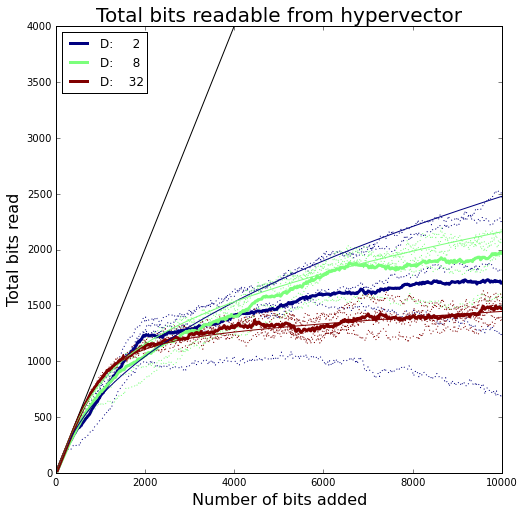

In [114]:
h = np.load('data/hypervector_capacity-totalbits-N=1-D=3-r=5-n160420.npz')
lidx_all = h['lidx_all']
totalbits_all = h['totalbits_all']

run_id = h['run_id']
run_N = h['run_N']
run_D = h['run_D']
runs = h['runs']
test_N = h['test_N']
test_D = h['test_D']
run_id = np.array(run_id)
run_D = np.array(run_D)

bit_factor = 20

uD = unique(run_D)
uN = unique(run_N)

tb_all = np.zeros((totalbits_all[0].shape[0], len(uD), runs))

for iD, idxD in enumerate(uD):
    idxs = find(run_D==idxD)
    for ii,i in enumerate(idxs):
        tb_all[:,iD,ii] = np.array(totalbits_all[i])
        
tb_mean = np.mean(tb_all, axis=2)


figure(figsize=(8,8))

plot_range = [0,test_N[0]*2]

cm=get_cmap('jet', tb_mean.shape[1])
smoothN=1
for i in range(tb_all.shape[1]):
    for j in range(tb_all.shape[2]):
        #plot(li_mean[:,i], color=cm(i))    
        plot(bit_factor * (arange(tb_all.shape[0]) + 1), 
             tb_all[:,i,j], ':', color=cm(i), lw=1)
        
        
for i in range(tb_mean.shape[1]):
    plot(bit_factor * (arange(tb_mean.shape[0])+1),
        tb_mean[:,i], color=cm(i), lw=3, label="D: %5i" % test_D[i])
        

plot(plot_range, plot_range, 'k')
 
for idxD, iD in enumerate(uD):
    for idxN, iN in enumerate(uN):
        bit_ratio = bit_factor / np.log2(iD)
  
        M = np.arange(1, 2*bit_ratio * tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        plot(np.log2(iD) * (M), 
             M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
             color=cm(idxD), lw=1)
legend(loc='upper left');
title('Total bits readable from hypervector', fontsize=20);
xlabel('Number of bits added', fontsize=16);
ylabel('Total bits read', fontsize=16)
xlim([0, 10000])
ylim(plot_range)


ValueError: operands could not be broadcast together with shapes (999,) (1000,) 

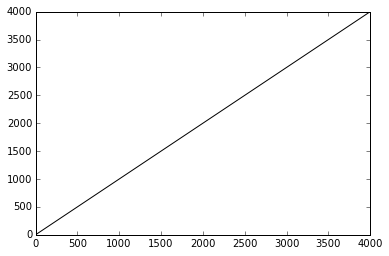

In [98]:
plot(plot_range, plot_range, 'k')

uD  = [2,4,8,16,32,64,128]
cm=get_cmap('jet', len(uD))

for idxD, iD in enumerate(uD):
    for idxN, iN in enumerate(uN):
        bit_ratio = bit_factor / np.log2(iD)
  
        M = np.linspace(1, 5*bit_ratio * tb_mean.shape[0], tb_mean.shape[0])
        #subplot(1, len(uD), idxD)
        plot(np.log2(iD) * (M), 
             M * np.log2(iD) * (1.0/(1-1.0/iD)) * (p_correct_l2(M, N=iN, D=iD) - 1.0/iD), 
             color=cm(idxD), lw=1)
        
ylim([0, 4000])


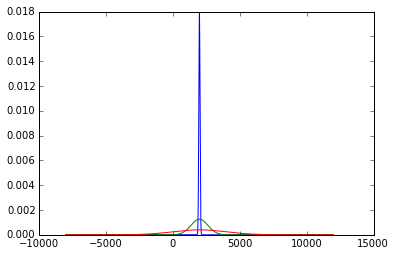

In [91]:
N=2000
M=[2, 200, 2000]

M = np.array(M)

avals = np.linspace(N - 5 * (N*np.max(M))**0.5, N+5*(N*np.max(M))**0.5, 10000)
p = np.zeros((len(avals)-1, len(M)))
for ia,a in enumerate(avals[1:]):
    p[ia, :] = ncdf(float(avals[ia+1]-N)/((M-1)*N)**0.5) - ncdf(float(avals[ia]-N)/((M-1)*N)**0.5)
    
plot(avals[1:], p)

In [70]:
len(M)

TypeError: len() of unsized object